<a href="https://colab.research.google.com/github/jonatpz/practicas-finales-ml-u3-u4/blob/main/Jonathan_P_Random_Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A fondo: Árboles de decisón y Bosques aleatorios

Anteriormente hemos analizado en profundidad un clasificador generativo simple (Bayes ingenuo; ver [En profundidad: Clasificación ingenua de Bayes)](05.05-Naive-Bayes.ipynb))  y un potente clasificador discriminativo (máquinas de vectores de soporte; ver[ En profundidad: admite máquinas vectoriales](05.07-Support-Vector-Machines.ipynb)).
Aquí veremos otro algoritmo poderoso: un algoritmo no paramétrico llamado bosques aleatorios. Los bosques aleatorios son un ejemplo de un ensemblemétodo, es decir, uno que se basa en agregar los resultados de un conjunto de estimadores más simples. El resultado algo sorprendente de estos métodos de conjunto es que la suma puede ser mayor que las partes: es decir, ¡la precisión predictiva de una votación mayoritaria entre varios estimadores puede terminar siendo mejor que la de cualquiera de los estimadores individuales que realizan la votación! Veremos ejemplos de esto en las siguientes secciones.

Comenzamos con las importaciones estándar:


In [ ]:
!pip install seaborn
import seaborn as sns

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")

## Motivación de los Bosques Aleatorios: Árboles de Decisión

Los bosques aleatorios son un ejemplo de un aprendizaje conjunto construido sobre árboles de decisión. Por esta razón, comenzaremos discutiendo los árboles de decisión en sí.

Los árboles de decisión son formas extremadamente intuitivas de clasificar o etiquetar objetos: simplemente se hacen una serie de preguntas diseñadas para centrarse en la clasificación. Por ejemplo, si quisieras construir un árbol de decisiones para clasificar los animales que encuentras durante una caminata, podrías construir el que se muestra en la siguiente figura.

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree.png?raw=1)
[Figura fuente en el Apéndice](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Example)

La división binaria hace que esto sea extremadamente eficiente: en un árbol bien construido, cada pregunta reducirá el número de opciones aproximadamente a la mitad, reduciendo muy rápidamente las opciones incluso entre un gran número de clases. El truco, por supuesto, consiste en decidir qué preguntas hacer en cada paso. En las implementaciones de aprendizaje automático de árboles de decisión, las preguntas generalmente toman la forma de divisiones alineadas con ejes en los datos: es decir, cada nodo del árbol divide los datos en dos grupos utilizando un valor de corte dentro de una de las características. Veamos ahora un ejemplo de esto.

### Creación de un árbol de decición

Considere los siguientes datos bidimensionales, que tienen una de cuatro etiquetas de clase (consulte la siguiente figura):

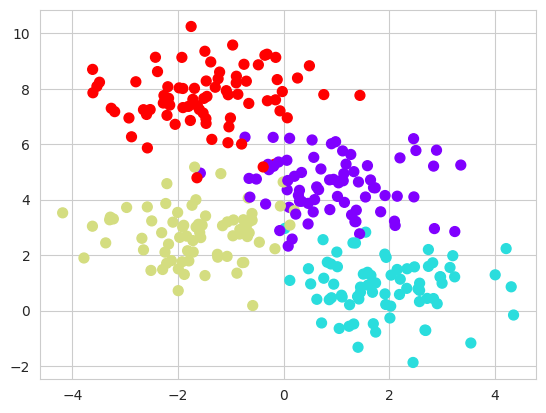

In [ ]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

Un árbol de decisión simple construido sobre estos datos dividirá iterativamente los datos a lo largo de uno u otro eje de acuerdo con algún criterio cuantitativo, y en cada nivel asignará la etiqueta de la nueva región de acuerdo con una mayoría de votos de puntos dentro de ella. La siguiente figura presenta una visualización de los primeros cuatro niveles de un clasificador de árbol de decisión para estos datos.

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree-levels.png?raw=1)
[Figura fuente en el Apéndice](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Levels)

Observa que después de la primera división, cada punto en la rama superior permanece sin cambios, por lo que no hay necesidad de subdividir más esta rama. Excepto en los nodos que contienen únicamente un color, en cada nivel cada región se divide nuevamente según una de las dos características.

Este proceso de ajuste de un árbol de decisiones a nuestros datos se puede realizar en Scikit-Learn con el``DecisionTreeClassifier`` estimador:

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

Escribamos una función de utilidad que nos ayude a visualizar la salida del clasificador:

In [ ]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()

    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Ahora podemos examinar cómo se ve la clasificación del árbol de decisión (ver la siguiente figura):

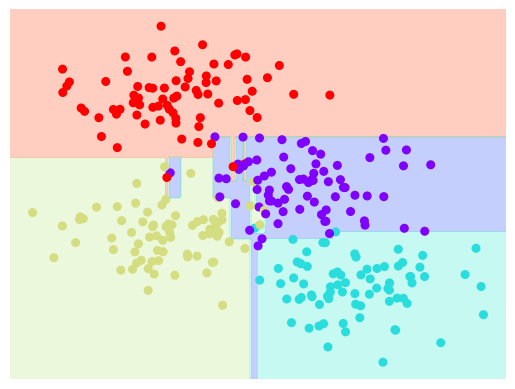

In [ ]:
visualize_classifier(DecisionTreeClassifier(), X, y)

In [ ]:

import helpers
helpers.plot_tree_interactive(X, y);

interactive(children=(IntSlider(value=5, description='depth', max=5, min=1), Output()), _dom_classes=('widget-…

Observe que a medida que aumenta la profundidad, tendemos a obtener regiones de clasificación con formas muy extrañas; por ejemplo, a una profundidad de cinco, hay una región violeta alta y delgada entre las regiones amarilla y azul. Está claro que esto es menos resultado de la distribución verdadera e intrínseca de los datos y más resultado de las propiedades particulares de muestreo o ruido de los datos. Es decir, este árbol de decisiones, incluso con sólo cinco niveles de profundidad, claramente sobreajusta nuestros datos.

### Árboles de decisión y sobreajuste

Este sobreajuste resulta ser una propiedad general de los árboles de decisión: es muy fácil profundizar demasiado en el árbol y, por lo tanto, ajustar los detalles de los datos particulares en lugar de las propiedades generales de las distribuciones de las que se extraen. Otra forma de ver este sobreajuste es observar modelos entrenados en diferentes subconjuntos de datos —por ejemplo, en esta figura entrenamos dos árboles diferentes, cada uno en la mitad de los datos originales.

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree-overfitting.png?raw=1)
[ Figura fuente en el Apéndice](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Overfitting)


Está claro que en algunos lugares los dos árboles producen resultados consistentes (por ejemplo, en las cuatro esquinas), mientras que en otros lugares los dos árboles dan clasificaciones muy diferentes (por ejemplo, en las regiones entre dos grupos cualesquiera). La observación clave es que las inconsistencias tienden a ocurrir donde la clasificación es menos segura y, por lo tanto, al utilizar información de ambos ¡De estos árboles podríamos obtener un mejor resultado!

Si está ejecutando este cuaderno en vivo, la siguiente función le permitirá mostrar de forma interactiva los ajustes de árboles entrenados en un subconjunto aleatorio de datos:

In [ ]:
# helpers_05_08 is found in the online appendix
import helpers
helpers.randomized_tree_interactive(X, y)

interactive(children=(IntSlider(value=0, description='random_state'), Output()), _dom_classes=('widget-interac…

Así como el uso de información de dos árboles mejora nuestros resultados, podríamos esperar que el uso de información de muchos árboles mejore aún más nuestros resultados.

Esta noción —de que se pueden combinar múltiples estimadores de sobreajuste para reducir el efecto de este sobreajuste— es lo que subyace a un método de conjunto llamado embolsado. Bagging utiliza un conjunto (quizás una bolsa de captura) de estimadores paralelos, cada uno de los cuales se ajusta en exceso a los datos y promedia los resultados para encontrar una mejor clasificación. Un conjunto de árboles de decisión aleatorios se conoce como bosque aleatorio.

Este tipo de clasificación de embolsado se puede realizar manualmente utilizando Scikit-Learn  `BaggingClassifier` metaestimador, como se muestra aquí (ver la siguiente figura):

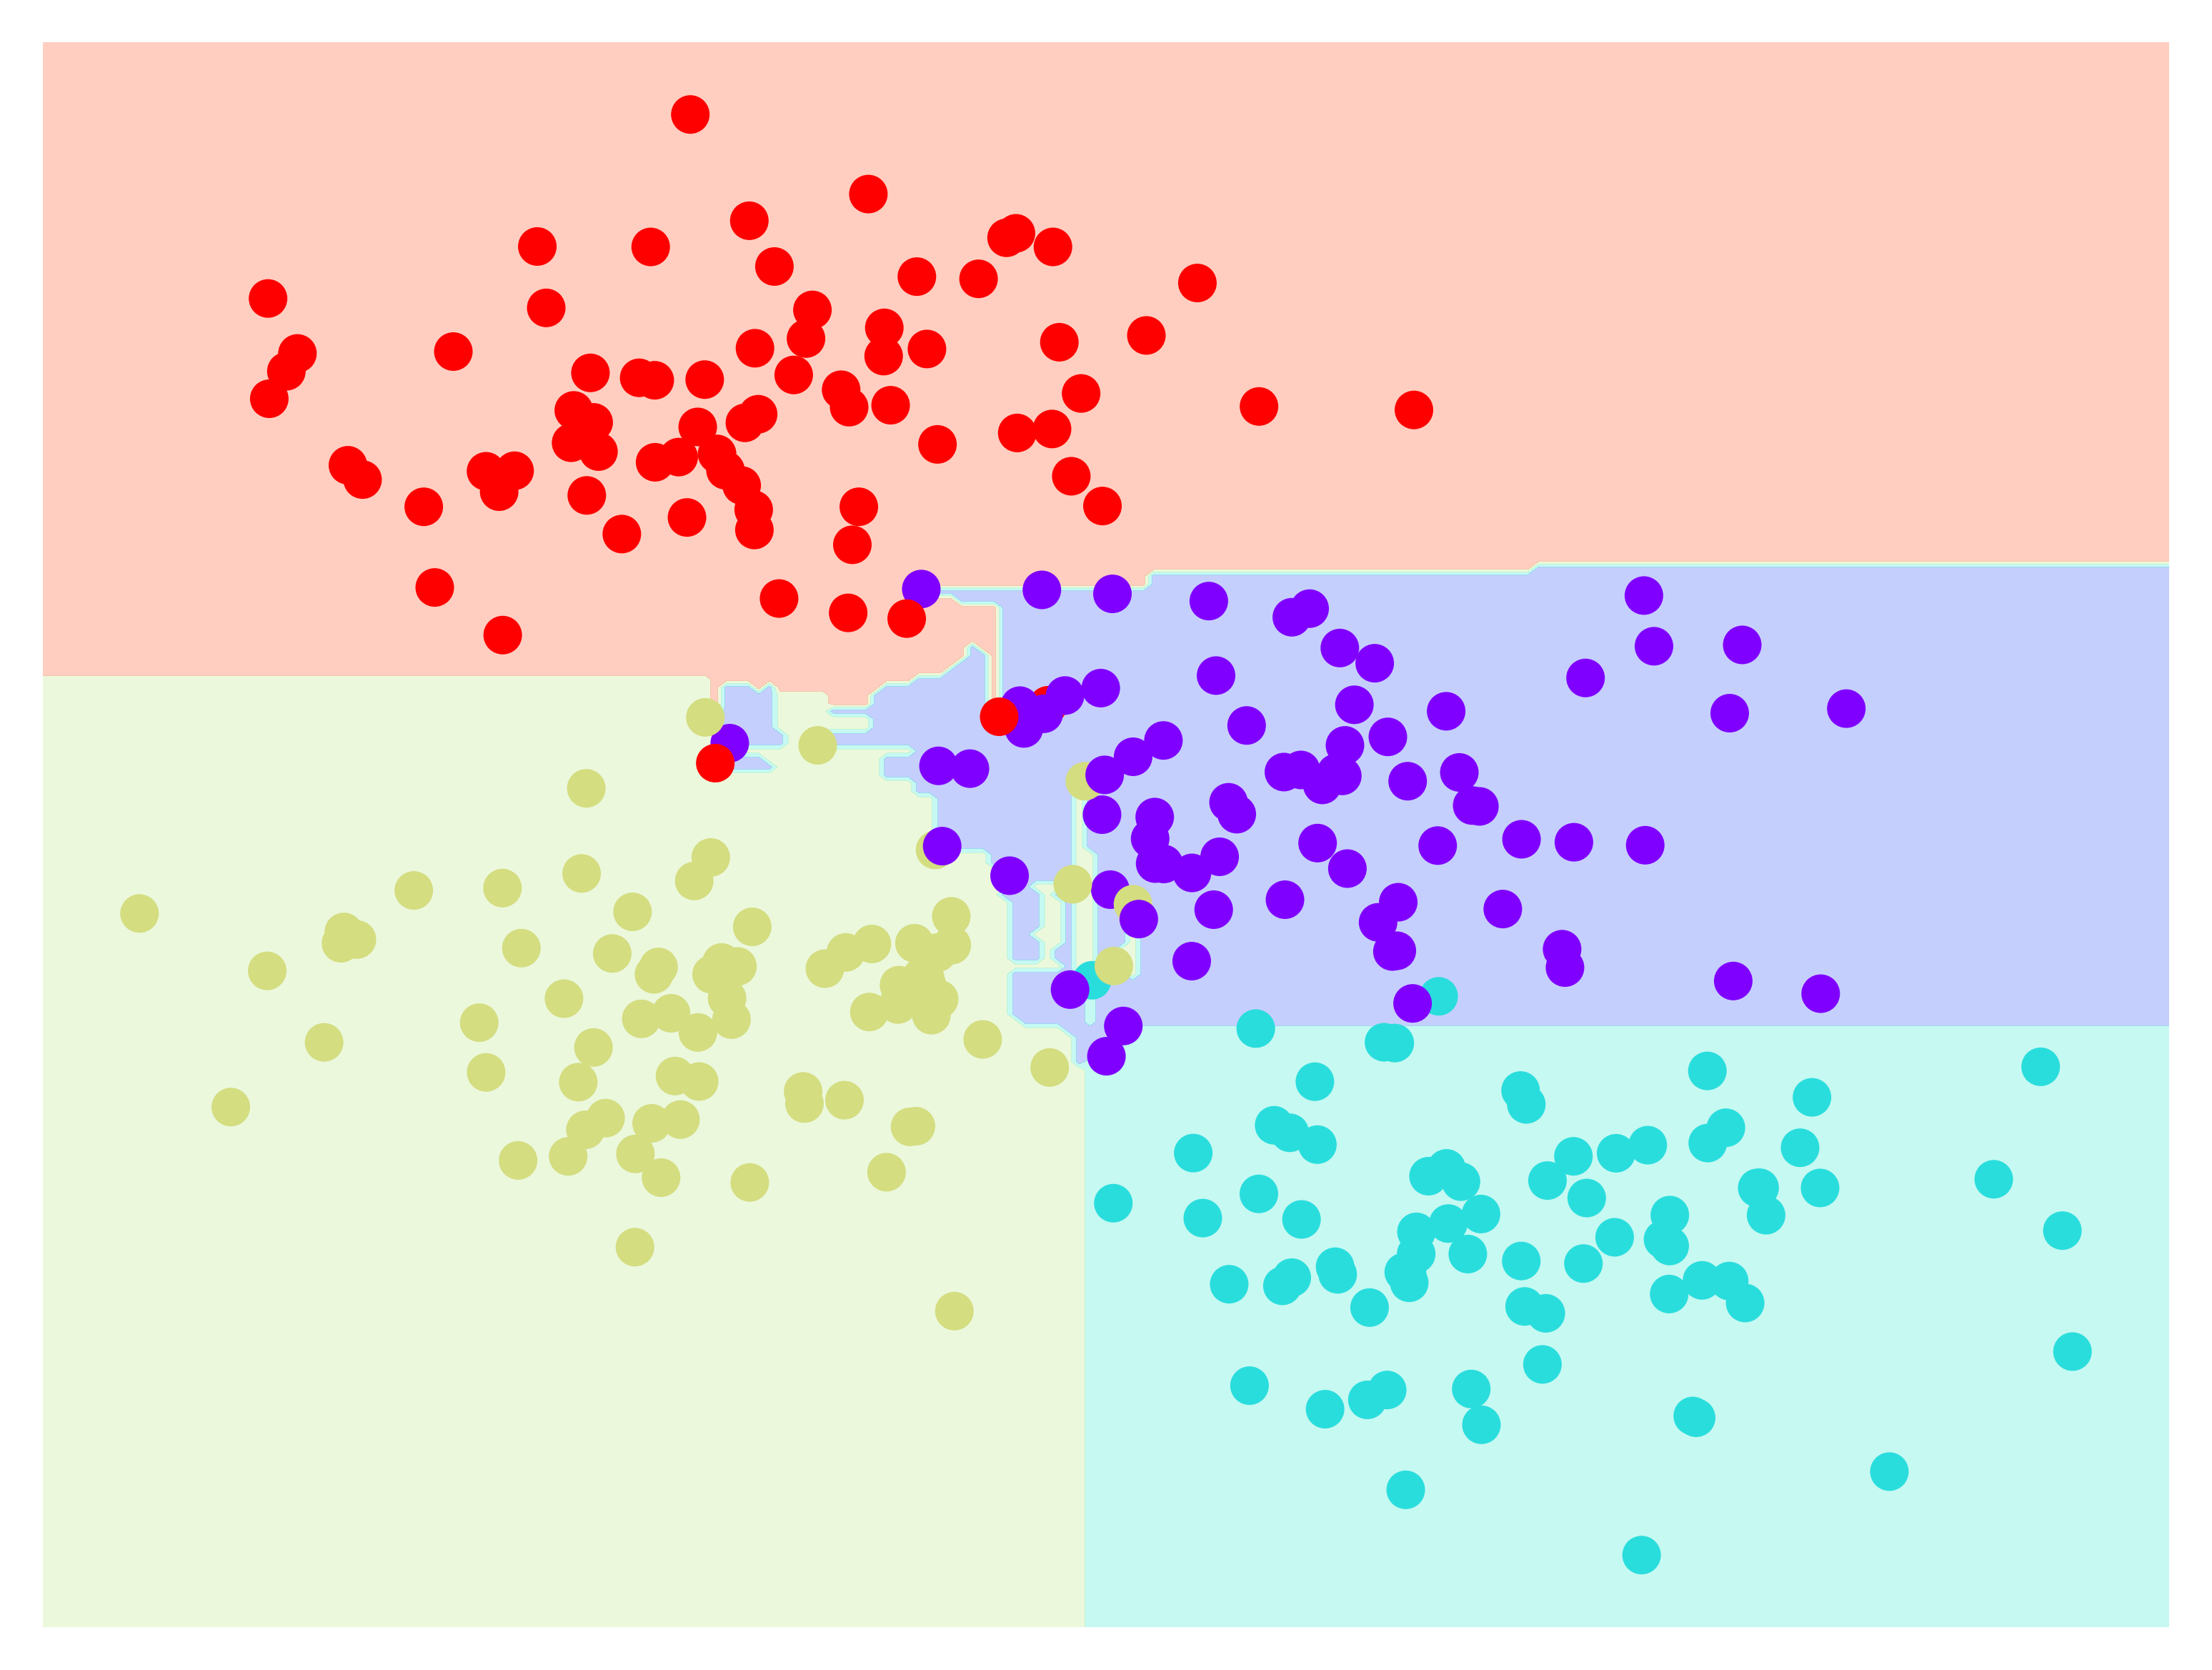

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

En este ejemplo, hemos aleatorizado los datos ajustando cada estimador con un subconjunto aleatorio del 80% de los puntos de entrenamiento. En la práctica, los árboles de decisión se aleatorizan de manera más efectiva al inyectar cierta estocasticidad en la forma en que se eligen las divisiones: de esta manera, todos los datos contribuyen al ajuste cada vez, pero los resultados del ajuste aún tienen la aleatoriedad deseada. Por ejemplo, al determinar qué característica dividir, el árbol aleatorio podría seleccionar entre las principales características. Puede leer más detalles técnicos sobre estas estrategias de aleatorización en el [Documentación Scikit-Learn](http://scikit-learn.org/stable/modules/ensemble.html#forest) y referencias dentro.

En Scikit-Learn, este conjunto optimizado de árboles de decisión aleatorios se implementa en`RandomForestClassifier`  estimador, que se encarga de toda la aleatorización de forma automática. Todo lo que necesita hacer es seleccionar una serie de estimadores, y muy rápidamente —en paralelo, si lo desea— se ajustará al conjunto de árboles (consulte la siguiente figura):

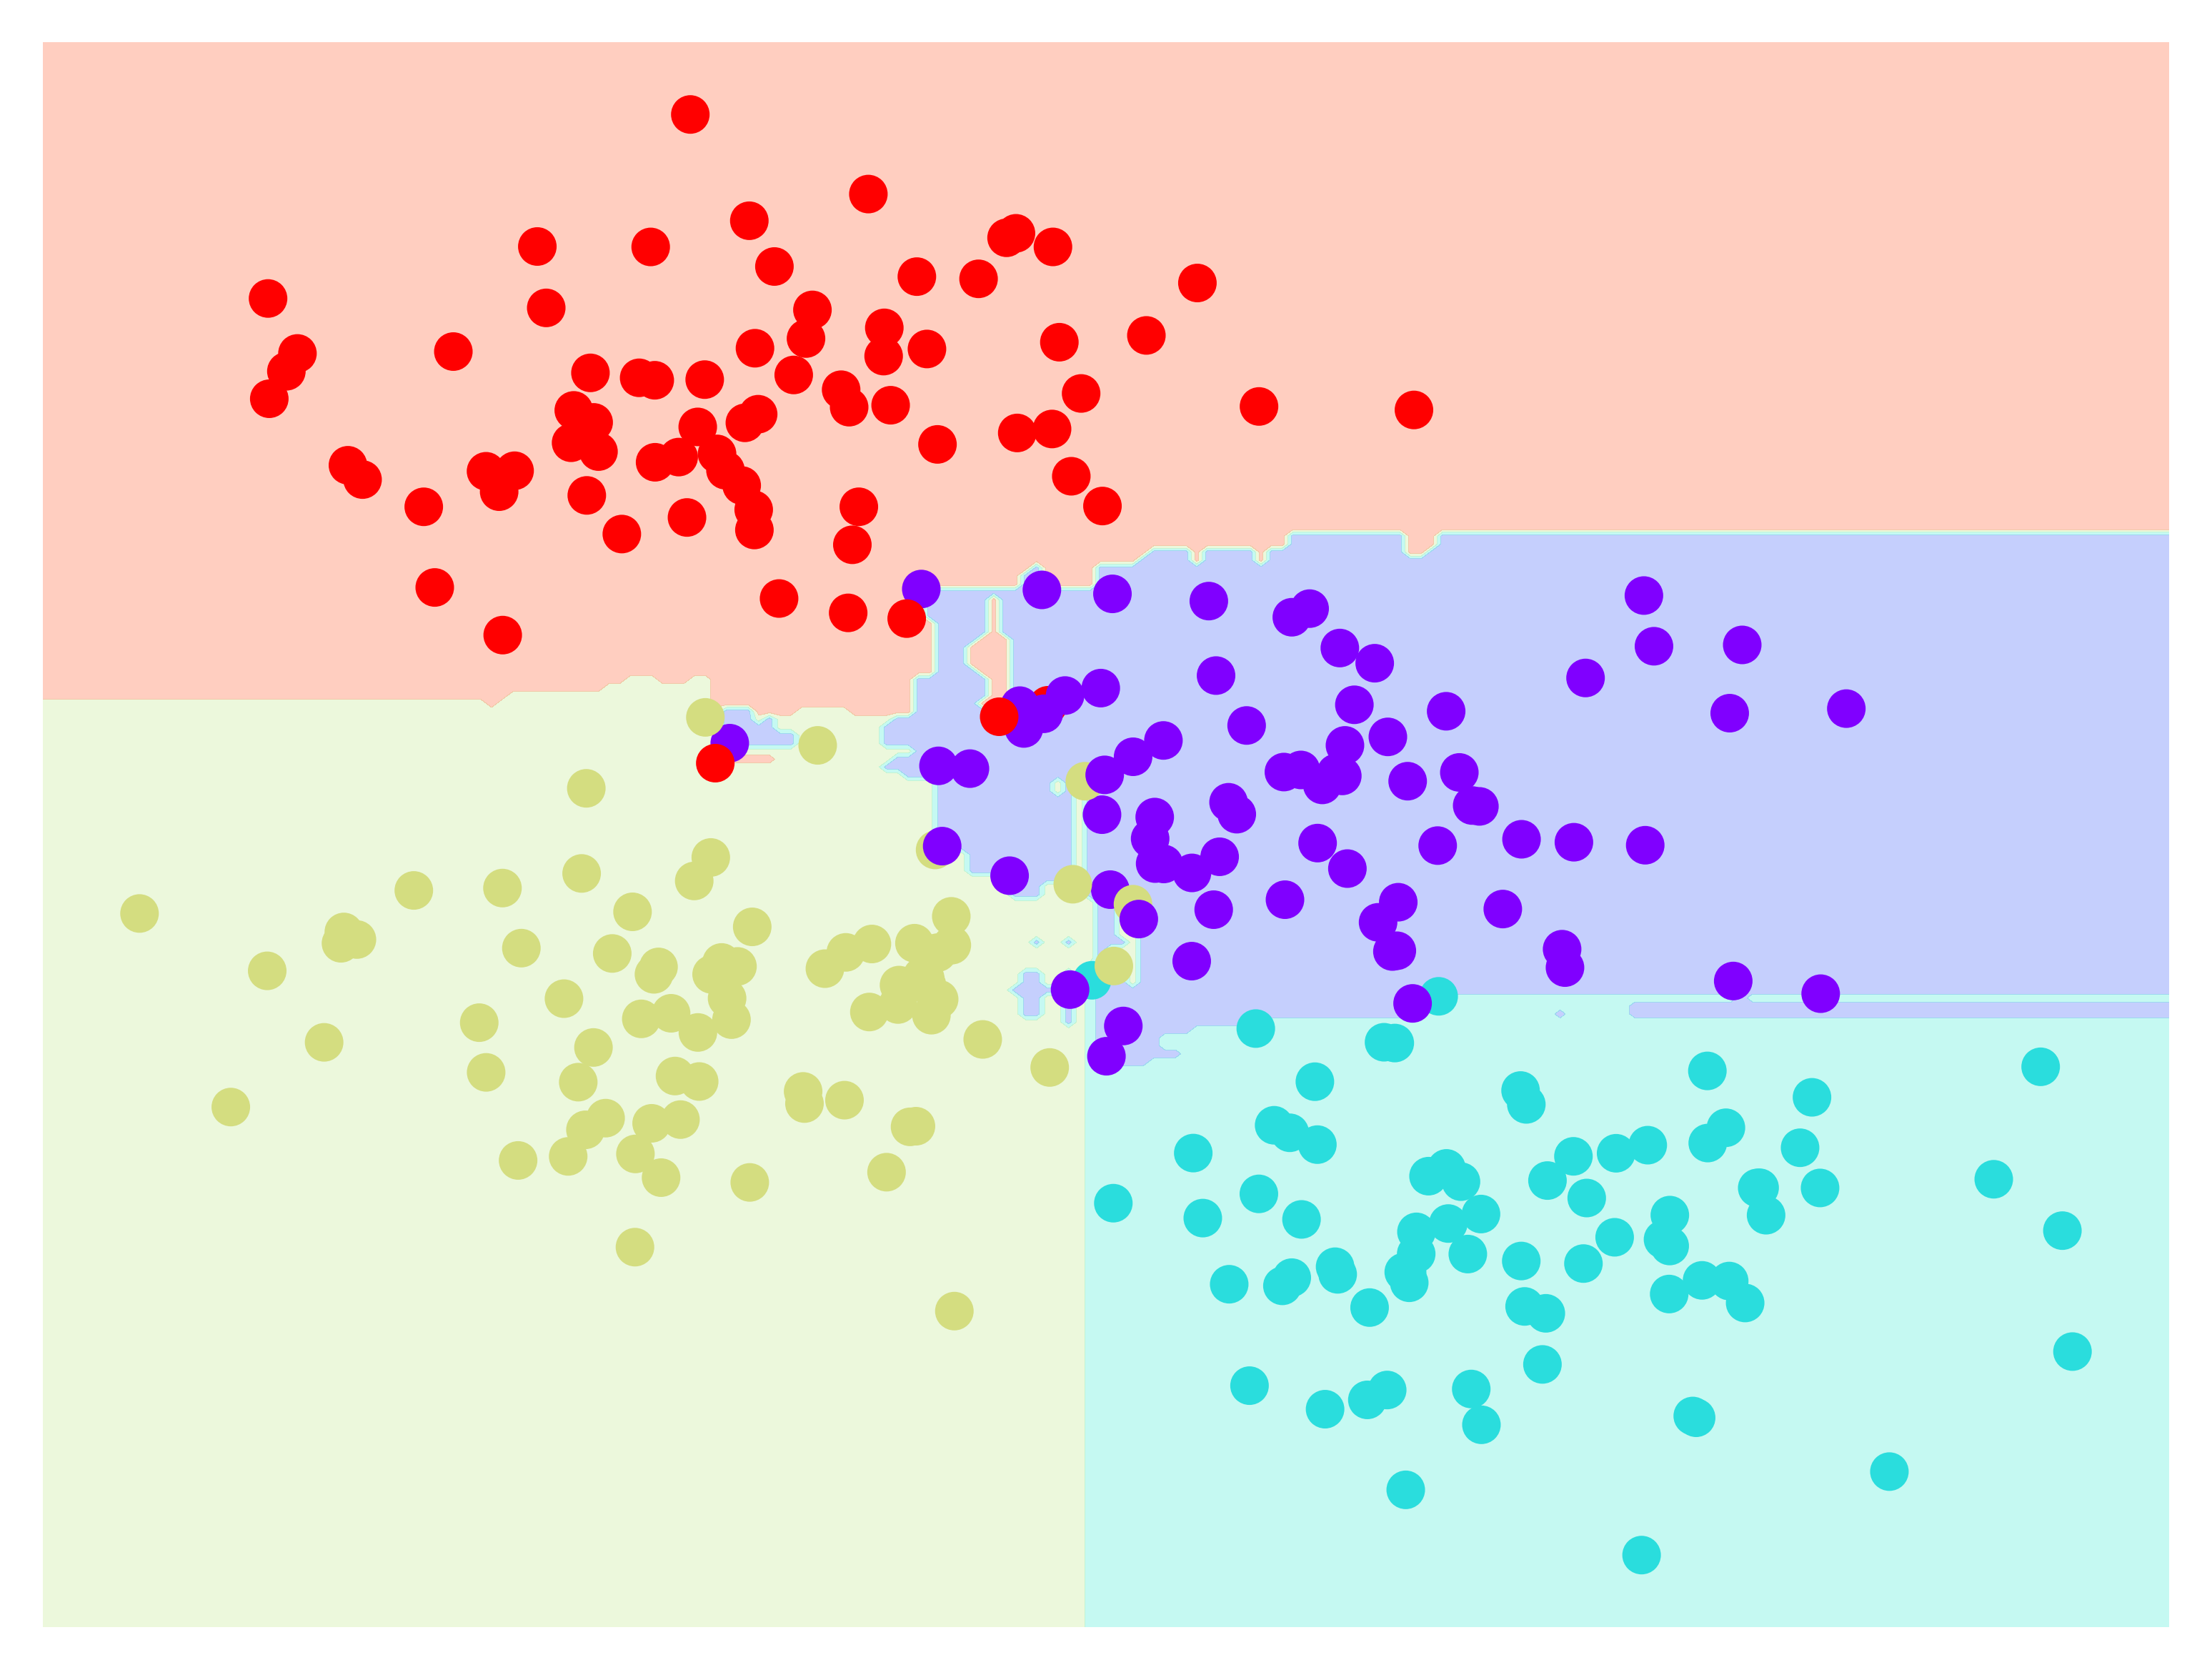

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

Vemos que al promediar más de 100 modelos perturbados aleatoriamente, terminamos con un modelo general que está mucho más cerca de nuestra intuición sobre cómo se debe dividir el espacio de parámetros.

## Regresión aleatoria del bosque

En la sección anterior consideramos bosques aleatorios dentro del contexto de la clasificación. También se puede hacer que los bosques aleatorios funcionen en el caso de regresión (es decir, con variables continuas en lugar de categóricas). El estimador a utilizar para esto es el `RandomForestRegressor`, y la sintaxis es muy similar a lo que vimos antes.

Considere los siguientes datos, extraídos de la combinación de una oscilación rápida y lenta (consulte la siguiente figura):

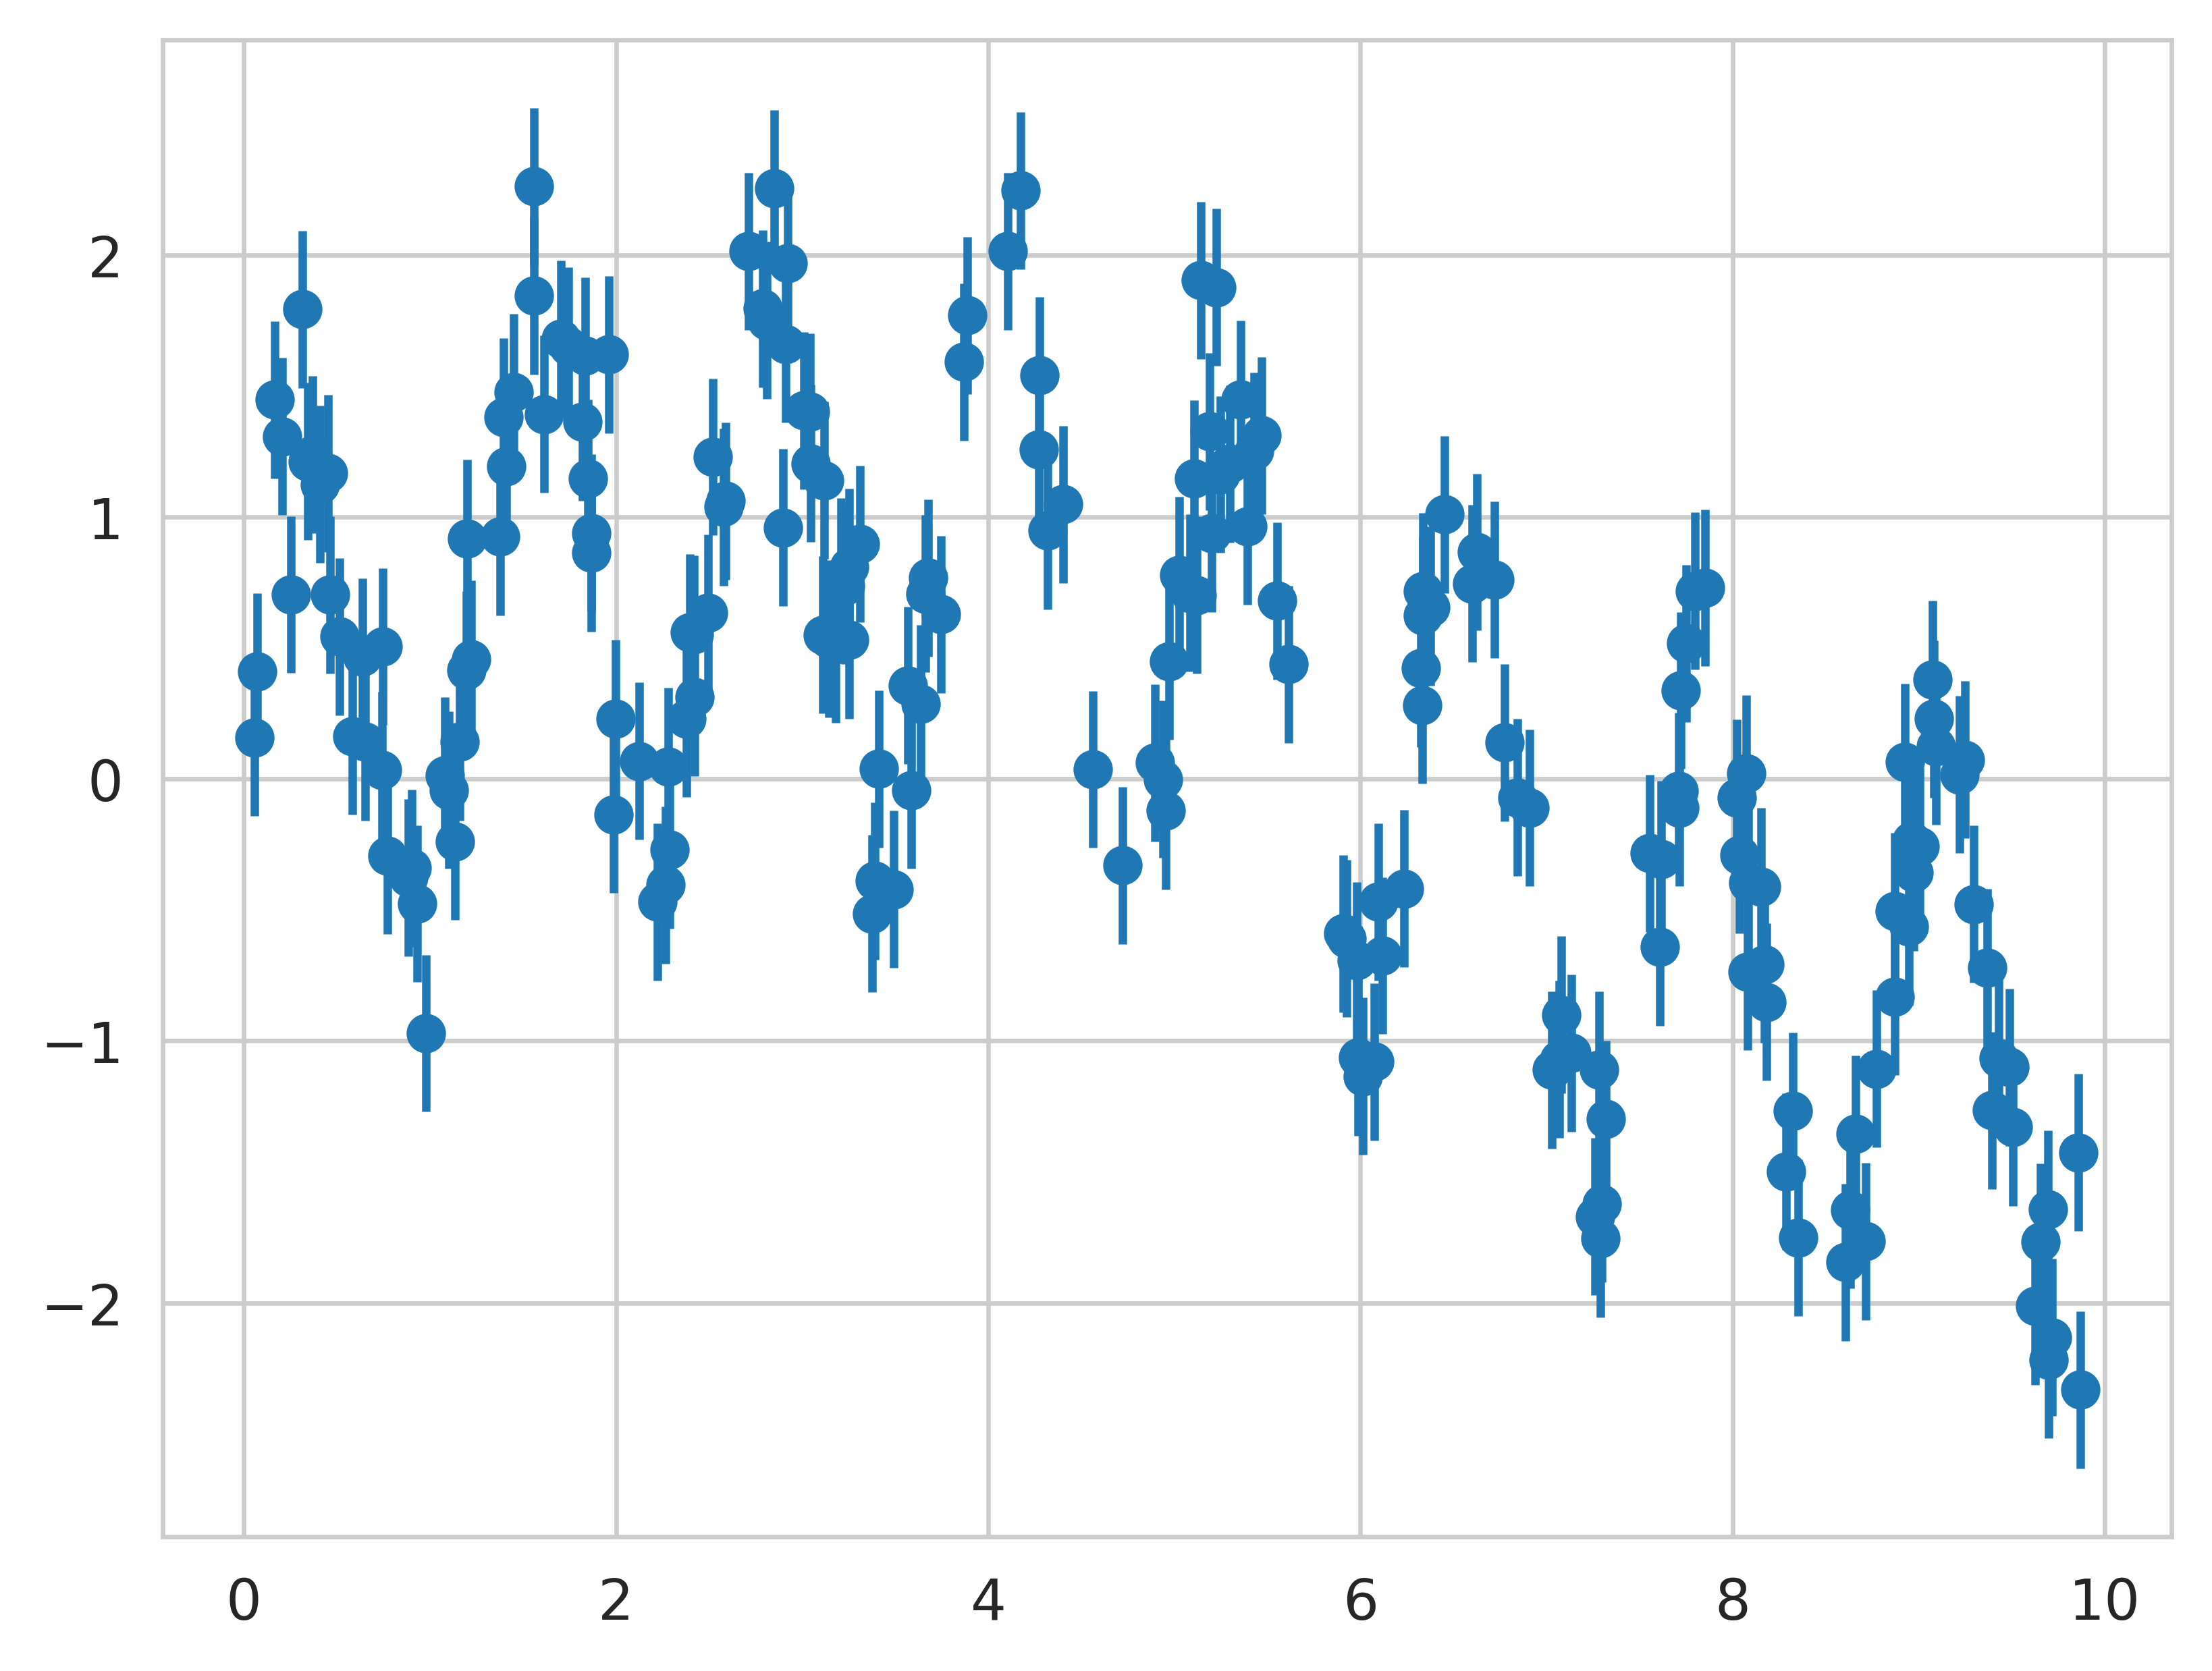

In [ ]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

Utilizando el regresor de bosque aleatorio, podemos encontrar la curva de mejor ajuste de la siguiente manera (ver la siguiente figura):

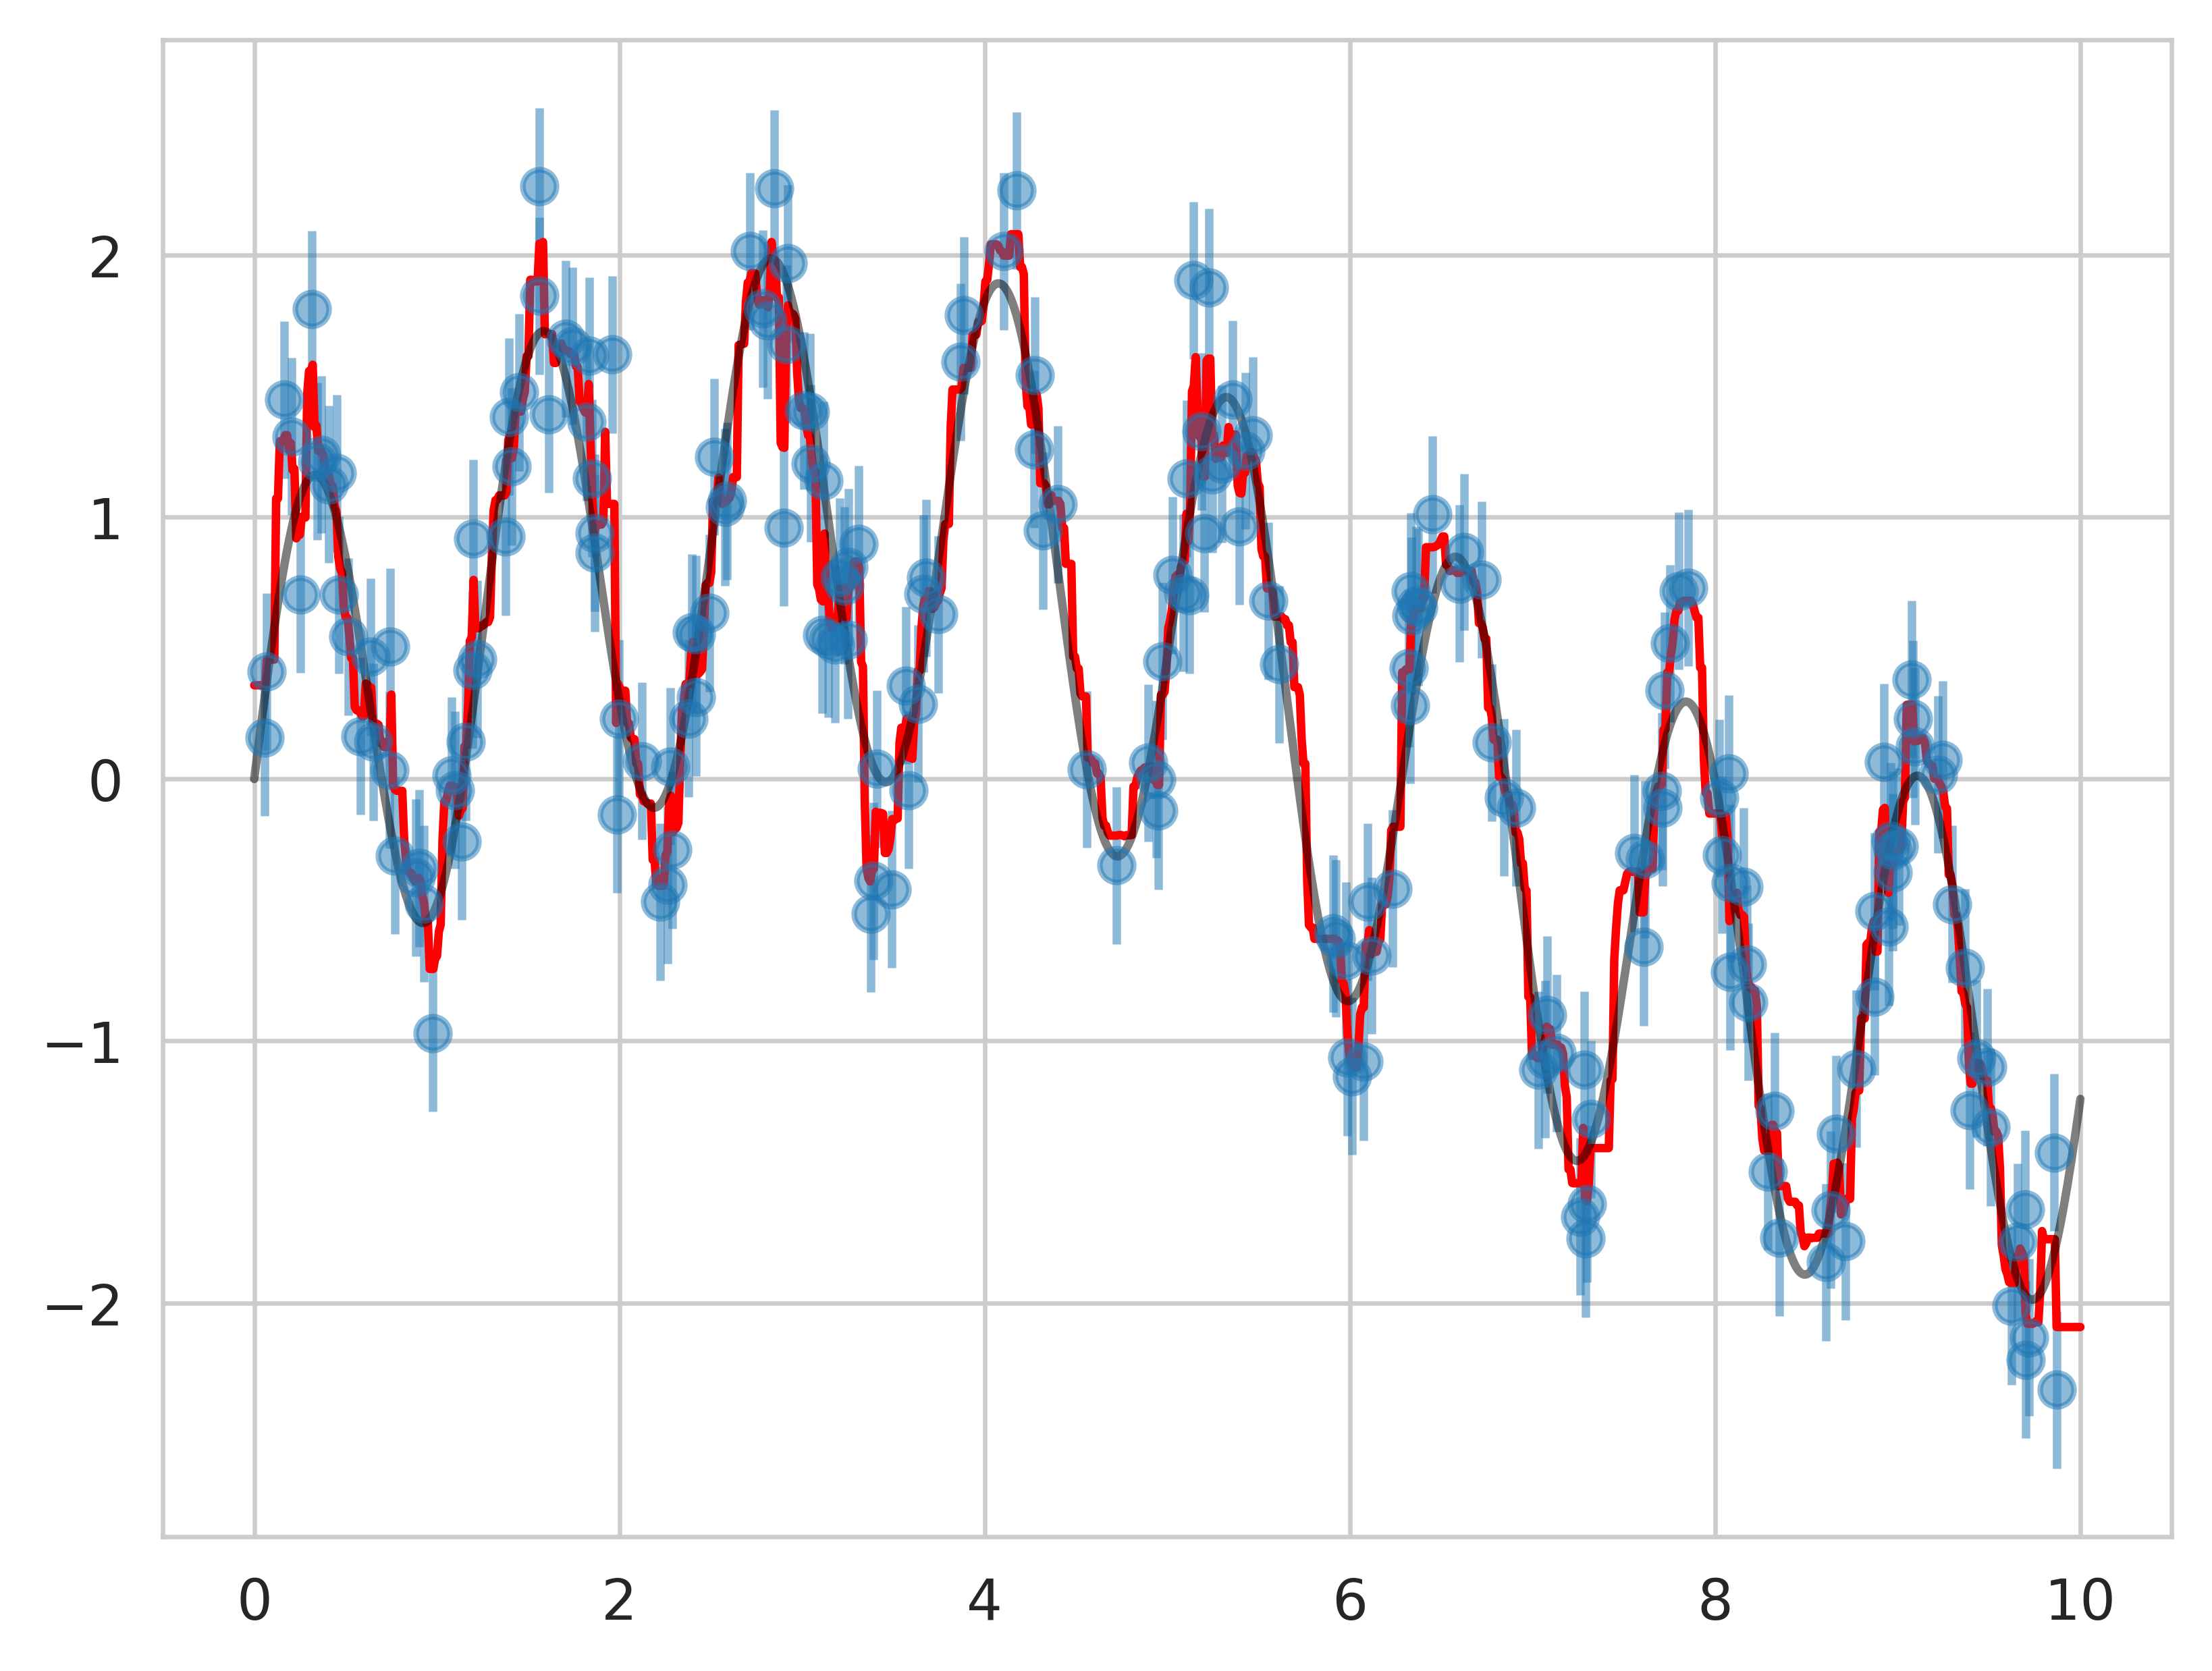

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Aquí el modelo verdadero se muestra en la curva gris suave, mientras que el modelo de bosque aleatorio se muestra mediante la curva roja irregular. El modelo de bosque aleatorio no paramétrico es lo suficientemente flexible como para ajustarse a los datos de múltiples períodos, ¡sin que necesitemos especificar un modelo de múltiples períodos!

## Ejemplo: Bosque aleatorio para clasificar dígitos

En el Capítulo 38 trabajamos con un ejemplo utilizando el conjunto de datos de dígitos incluido con Scikit-Learn. Usemos eso nuevamente aquí para ver cómo se puede aplicar el clasificador de bosque aleatorio en este contexto:

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

Para recordarnos lo que estamos viendo, visualizaremos los primeros puntos de datos (ver la siguiente figura):

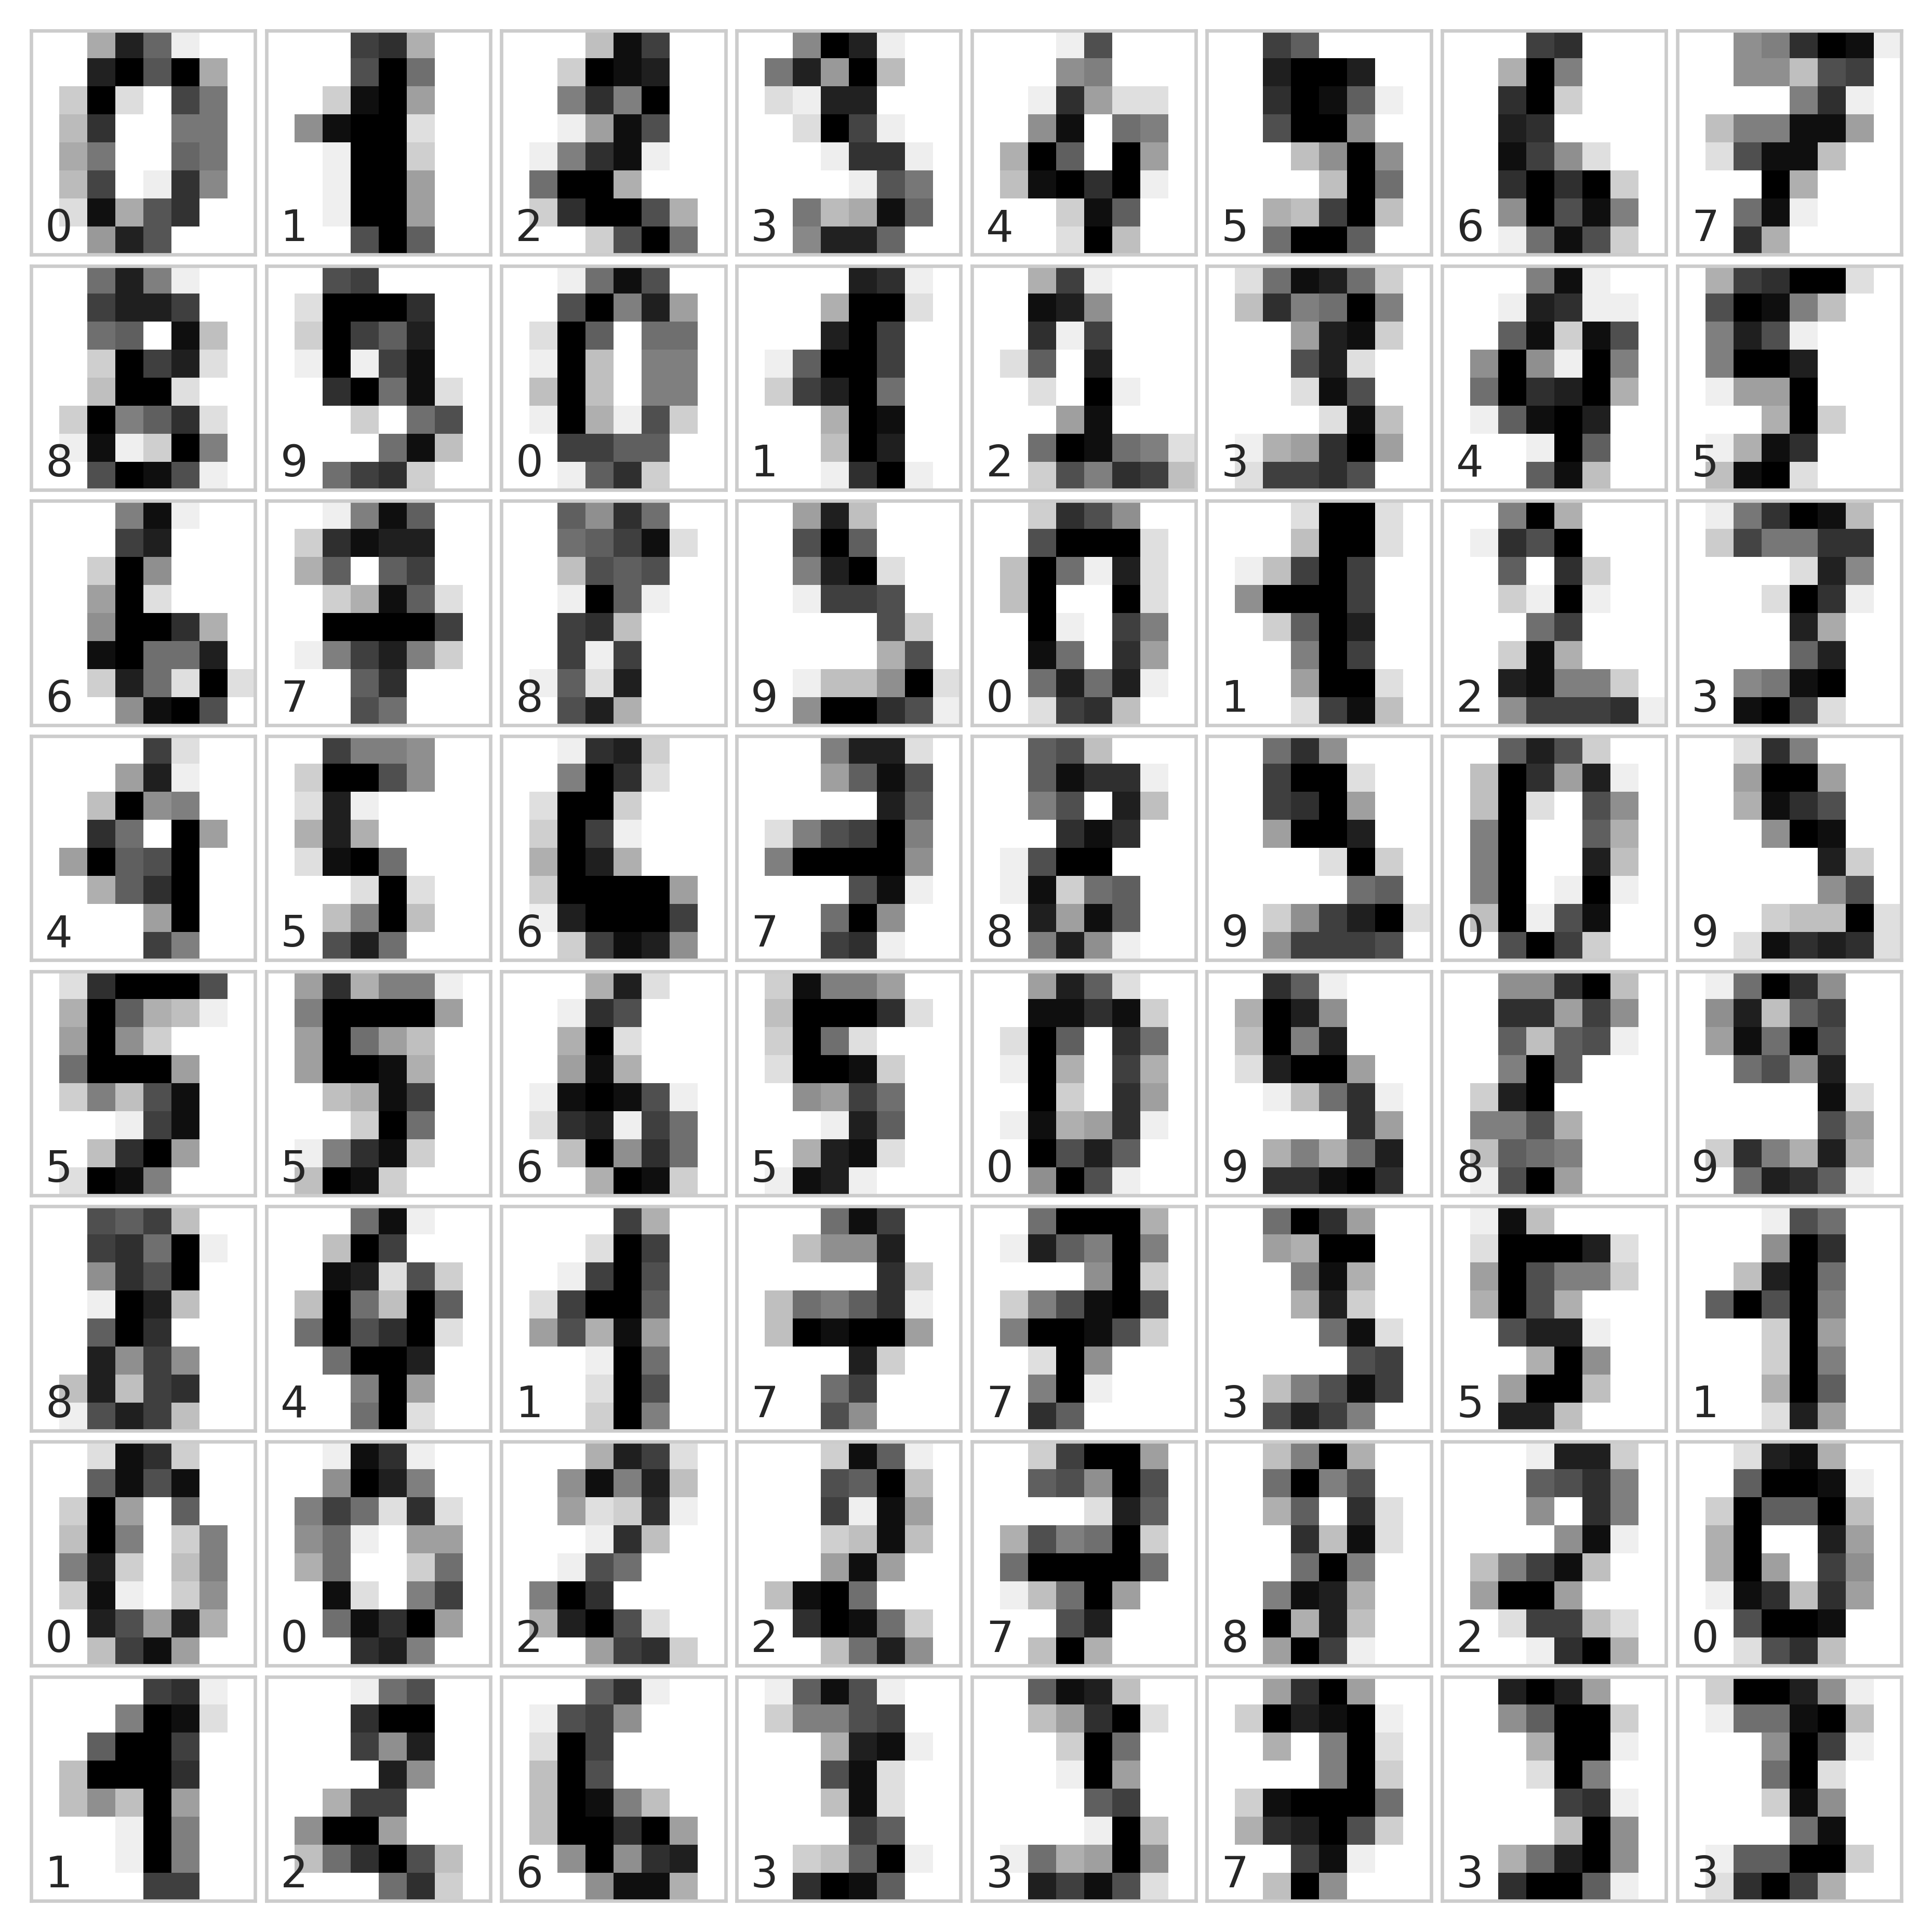

In [ ]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')

    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

Podemos clasificar los dígitos utilizando un bosque aleatorio de la siguiente manera:

In [ ]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

Veamos el informe de clasificación de este clasificador::

In [ ]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.98      0.98        43
           2       0.95      1.00      0.98        42
           3       0.98      0.96      0.97        46
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



Y por si acaso, grafique la matriz de confusión (ver la siguiente figura):

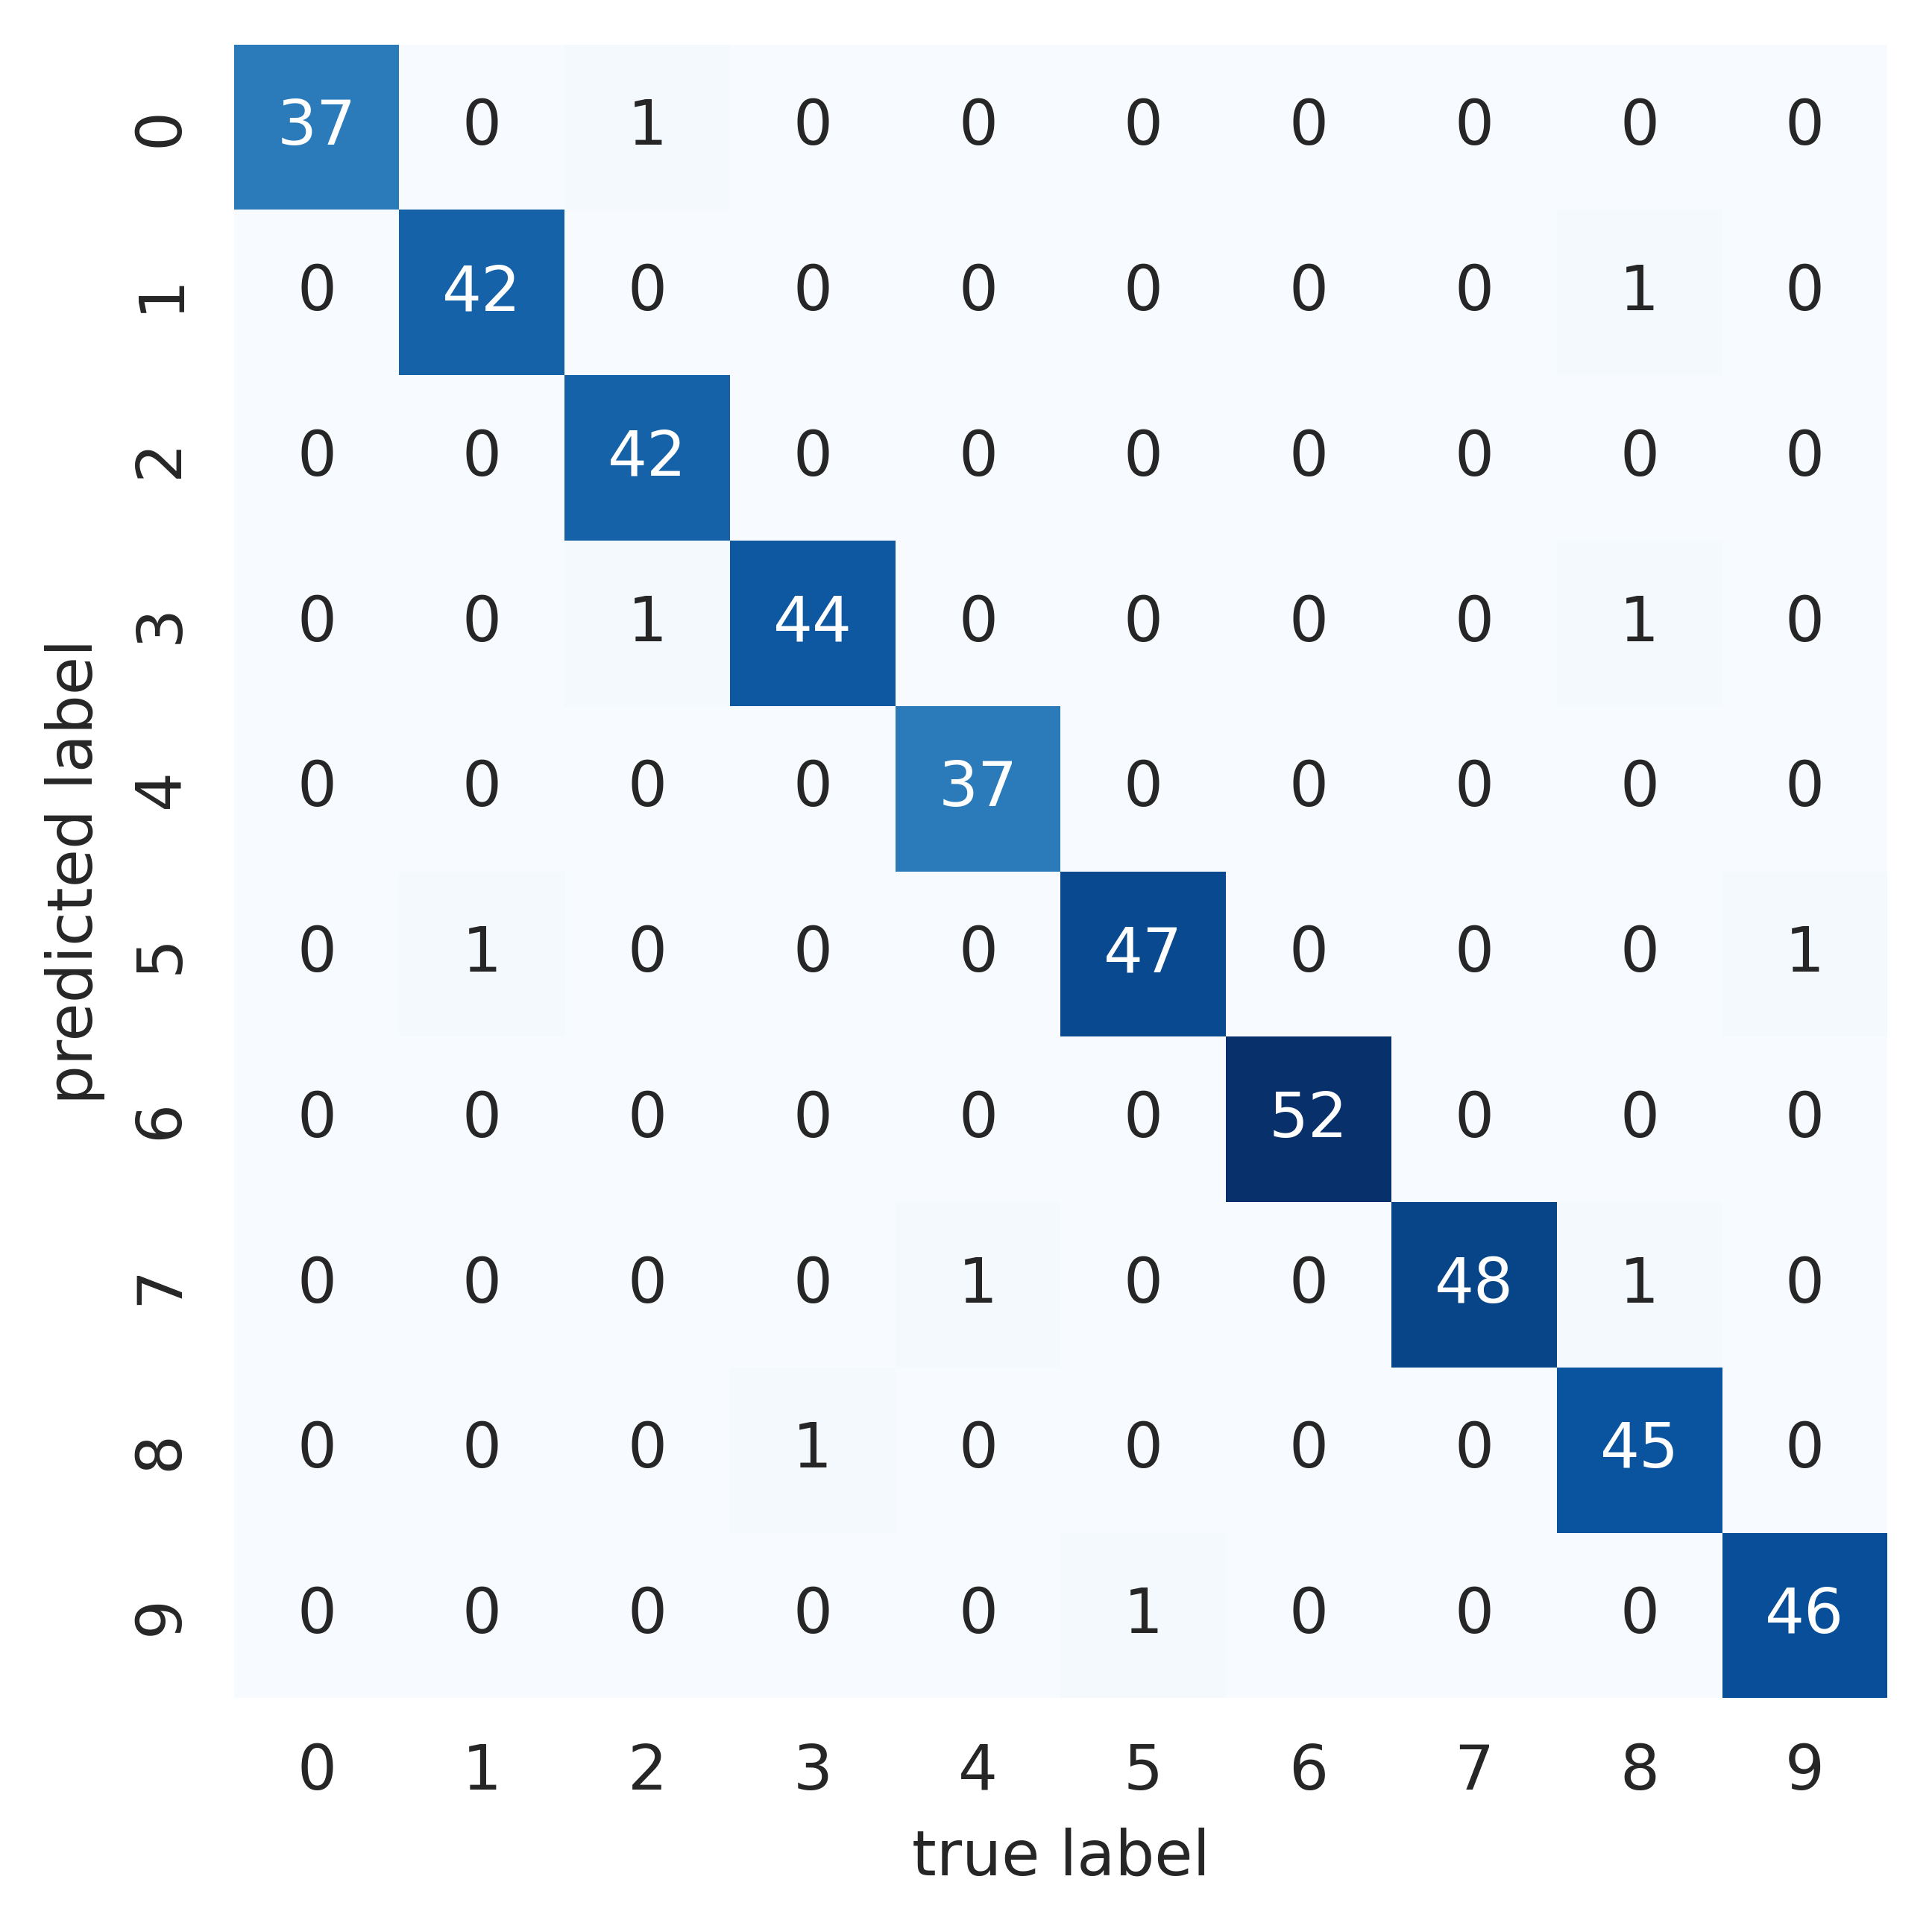

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues')
plt.xlabel('true label')
plt.ylabel('predicted label');

Descubrimos que un bosque aleatorio simple y no ajustado da como resultado una clasificación bastante precisa de los datos de los dígitos.

## Resumen

Este capítulo proporcionó una breve introducción al concepto de estimadores de conjunto y, en particular, al bosque aleatorio, un conjunto de árboles de decisión aleatorios. Los bosques aleatorios son un método poderoso con varias ventajas:

- Tanto el entrenamiento como la predicción son muy rápidos debido a la simplicidad de los árboles de decisión subyacentes. Además, ambas tareas se pueden paralelizar directamente, porque los árboles individuales son entidades completamente independientes.
- Los árboles múltiples permiten una clasificación probabilística: un voto mayoritario entre los estimadores da una estimación de la probabilidad (consultado en Scikit-Learn con el método `predict_proba`).
- El modelo no paramétrico es extremadamente flexible y, por lo tanto, puede funcionar bien en tareas que otros estimadores no ajustan adecuadamente.
Una desventaja principal de los bosques aleatorios es que los resultados no son fácilmente interpretables: es decir, si desea sacar conclusiones sobre el significado Del modelo de clasificación, los bosques aleatorios pueden no ser la mejor opción.